In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

from composition_stats import ilr, ilr_inv, closure
from statsmodels.tsa.seasonal import seasonal_decompose

In [18]:
raw_data = pd.read_excel("Datos_Market_copy.xlsx")

data = raw_data.copy()
data.set_index("date", inplace=True)

# Unify the brand names to 4 categories (brand-15, brand-14, brand-35, other)
for i in data["brand"]:
    if i != "brand-15" and i != "brand-14" and i != "brand-35":
        # change the name
        # test_data["brand"].replace(i, "other", inplace=True)
        data["brand"].replace({i: "other"}, inplace=True)


sales = ["volume.sales", "value.sales", "unit.sales"]

pack_size350 = data["pack.size"].isin(["0 - 350 GR"])
pack_size500 = data["pack.size"].isin(["351 - 500 GR"])
pack_size1000 = data["pack.size"].isin(["701 - 1000 GR"])
pack_size = data["pack.size"].isin(["0 - 350 GR", "351 - 500 GR"])

brand35 = data["brand"].isin(["brand-35"])
brand15 = data["brand"].isin(["brand-15"])
brand14 = data["brand"].isin(["brand-14"])
brandOther = data["brand"].isin(["other"])

variantF = data["variant"].isin(["flavoured"])
variantL = data["variant"].isin(["light"])
variantS = data["variant"].isin(["standard"])
variantV = data["variant"].isin(["vegan"])

supermarketA = data["supermarket"].isin(["supermarket-A"])
supermarketB = data["supermarket"].isin(["supermarket-B"])
supermarketC = data["supermarket"].isin(["supermarket-C"])
supermarketD = data["supermarket"].isin(["supermarket-D"])

/var/folders/r4/_d0jbzx9629841ty8b0gfn040000gn/T/ipykernel_22167/759143010.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data["brand"].replace({i: "other"}, inplace=True)


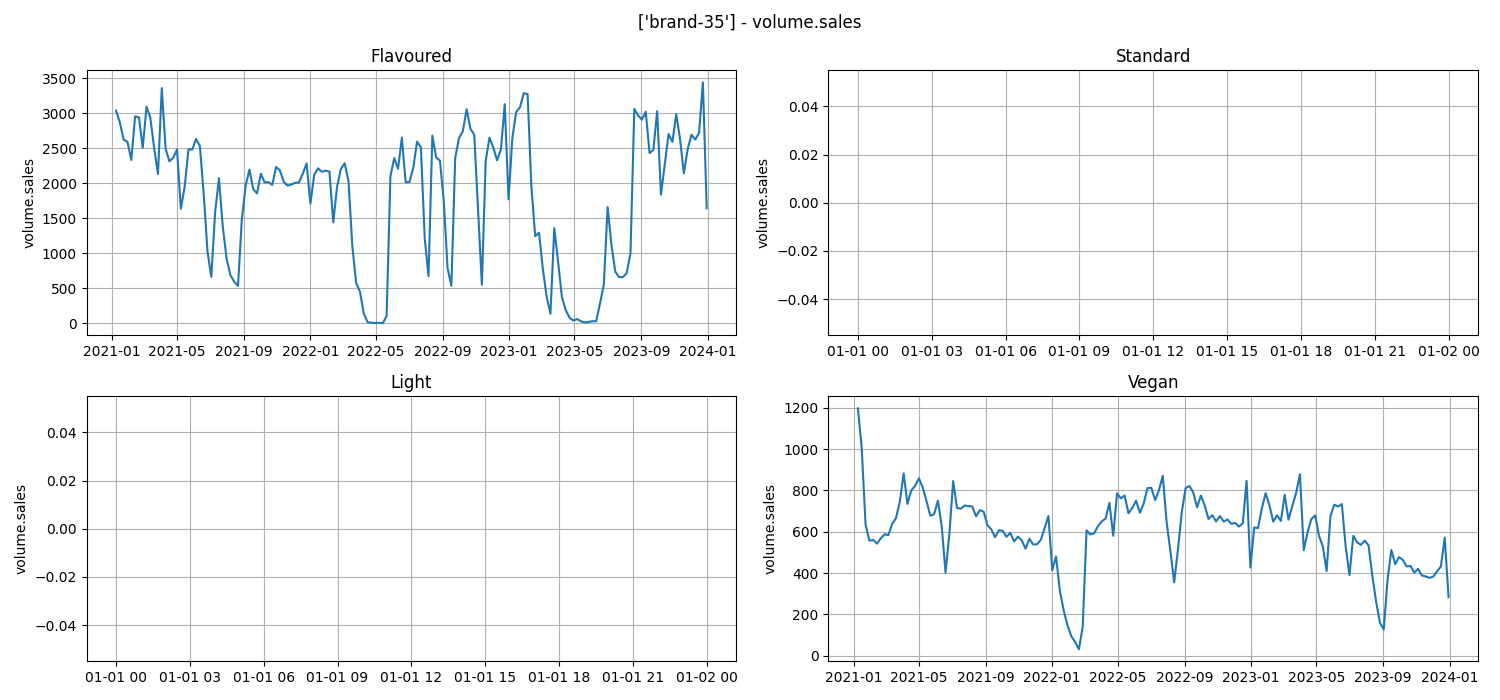

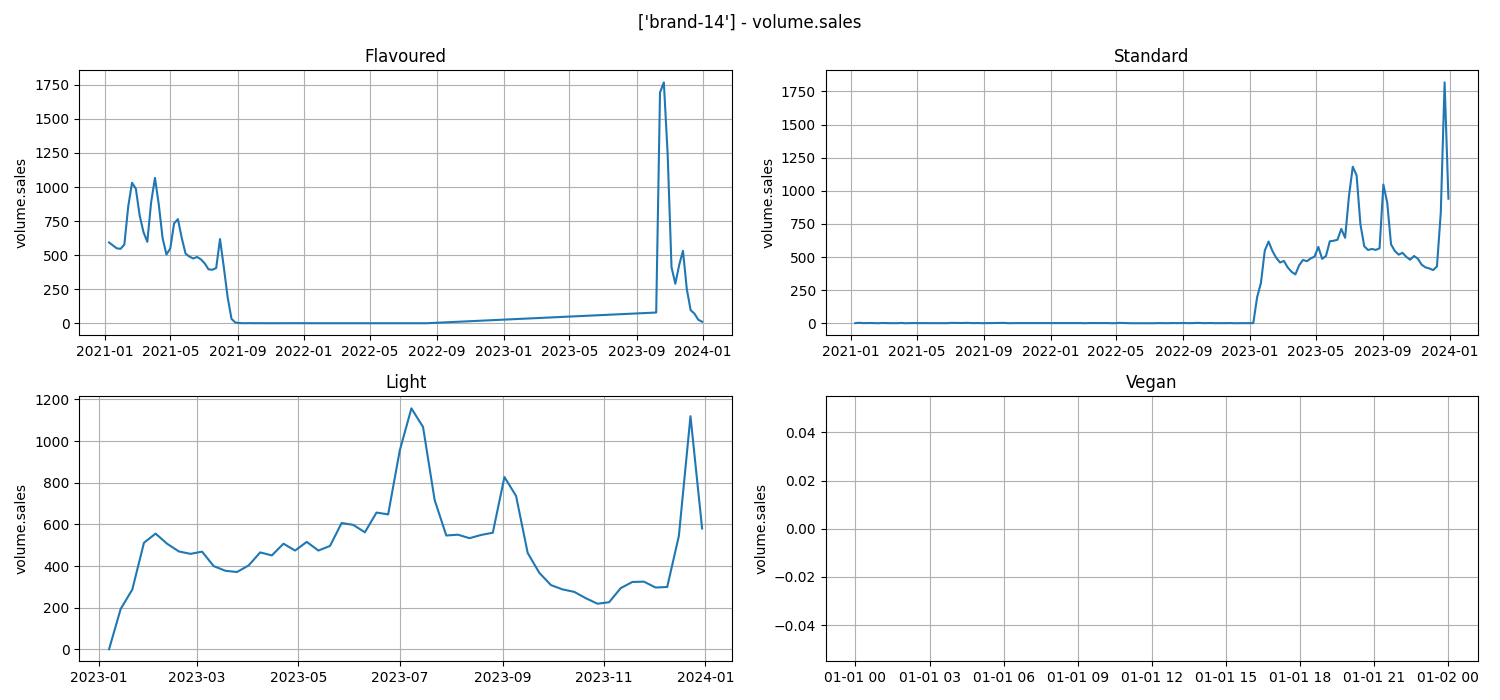

In [35]:
%matplotlib inline
def plot_data(brand, supermarket, pack_size, sales):
    fig, ax = plt.subplots(2, 2, figsize=(15, 7))

    ax[0, 0].plot(data[(brand) & (variantF) & (supermarket) & (pack_size)][sales])
    ax[0, 0].set_title("Flavoured")
    ax[0, 0].set_ylabel(sales)
    ax[0, 0].grid(True)

    ax[0, 1].plot(data[(brand) & (variantS) & (supermarket) & (pack_size)][sales])
    ax[0, 1].set_title("Standard")
    ax[0, 1].set_ylabel(sales)
    ax[0, 1].grid(True)

    ax[1, 0].plot(data[(brand) & (variantL) & (supermarket) & (pack_size)][sales])
    ax[1, 0].set_title("Light")
    ax[1, 0].set_ylabel(sales)
    ax[1, 0].grid(True)

    ax[1, 1].plot(data[(brand) & (variantV) & (supermarket) & (pack_size)][sales])
    ax[1, 1].set_title("Vegan")
    ax[1, 1].set_ylabel(sales)
    ax[1, 1].grid(True)

    plt.suptitle(f"{data[brand]['brand'].unique()} - {sales}")
    plt.tight_layout()
    plt.show()


%matplotlib widget
plot_data(brand35, pack_size350, supermarketA, "volume.sales")
# plot_data(brand15, pack_size350, supermarketA, "volume.sales")
plot_data(brand14, pack_size350, supermarketC, "volume.sales")
# plot_data(brandOther, pack_size, supermarketA, "volume.sales")

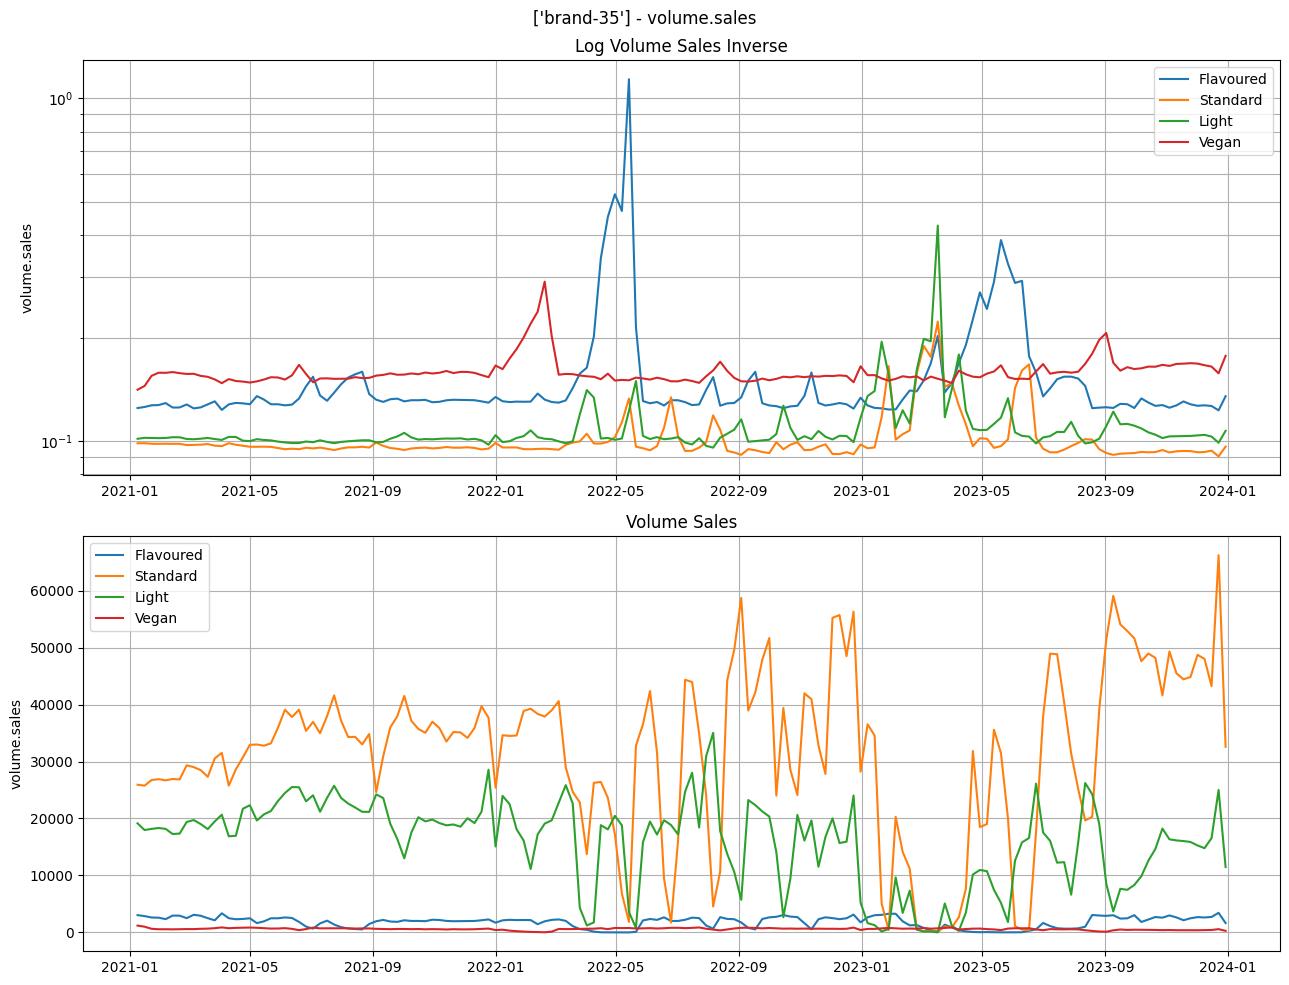

In [20]:
# haz logaritmo de las ventas
def log_graphs(brand, sales):
    fig, ax = plt.subplots(2, 1, figsize=(13, 10))

    ax[0].plot(
        1 / np.log(data[(brand) & (variantF) & (supermarketA) & (pack_size)][sales])
    )
    ax[0].plot(
        1 / np.log(data[(brand) & (variantS) & (supermarketA) & (pack_size)][sales])
    )
    ax[0].plot(
        1 / np.log(data[(brand) & (variantL) & (supermarketA) & (pack_size)][sales])
    )
    ax[0].plot(
        1 / np.log(data[(brand) & (variantV) & (supermarketA) & (pack_size)][sales])
    )
    ax[0].set_title("Log Volume Sales Inverse")
    ax[0].set_ylabel("volume.sales")
    ax[0].set_yscale("log")
    ax[0].grid(True, which="both")
    ax[0].legend(["Flavoured", "Standard", "Light", "Vegan"])

    ax[1].plot(
        data[(brand) & (variantF) & (supermarketA) & (pack_size)]["volume.sales"]
    )
    ax[1].plot(
        data[(brand) & (variantS) & (supermarketA) & (pack_size)]["volume.sales"]
    )
    ax[1].plot(
        data[(brand) & (variantL) & (supermarketA) & (pack_size)]["volume.sales"]
    )
    ax[1].plot(
        data[(brand) & (variantV) & (supermarketA) & (pack_size)]["volume.sales"]
    )
    ax[1].set_title("Volume Sales")
    ax[1].set_ylabel("volume.sales")
    ax[1].grid(
        True,
    )
    ax[1].legend(["Flavoured", "Standard", "Light", "Vegan"])

    plt.suptitle(f"{data[brand]['brand'].unique()} - {sales}")
    plt.tight_layout()
    plt.show()


log_graphs(brand35, "volume.sales")
# log_graphs(brand15, "volume.sales")
# log_graphs(brand14, "volume.sales")
# log_graphs(brandOther, "volume.sales")

In [38]:
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX


def modelization(data_filtered):

    # Create dummy variables for the supermarket column
    data_dummies = pd.get_dummies(
        data_filtered, columns=["supermarket", "variant"], drop_first=True
    )

    for col in [
        "supermarket_supermarket-B",
        "supermarket_supermarket-C",
        "supermarket_supermarket-D",
        "variant_light",
        "variant_standard",
        "variant_vegan",
        # "pack.size_351 - 500 GR",
        # "pack.size_701 - 1000 GR",
        # "pack.size_501 - 700 GR",
    ]:
        data_dummies[col] = data_dummies[col].astype(int)

    X = data_dummies[
        [
            "unit.sales",
            "value.sales",
            "supermarket_supermarket-B",
            "supermarket_supermarket-C",
            "supermarket_supermarket-D",
            "variant_light",
            "variant_standard",
            "variant_vegan",
            # "pack.size_351 - 500 GR",
            # "pack.size_701 - 1000 GR",
            # "pack.size_501 - 700 GR",
        ]
    ]

    X = sm.add_constant(X)

    y = data_dummies["volume.sales"]

    # Adjust the model
    model = sm.OLS(y, X).fit()

    model_summary = model.summary()

    return data_dummies, model


data_dummies, model = modelization(
    data[(brand35) & (pack_size350)]
)  # made the model for brand-35

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           volume.sales   R-squared:                       0.954
Model:                            OLS   Adj. R-squared:                  0.954
Method:                 Least Squares   F-statistic:                     3406.
Date:                Fri, 27 Sep 2024   Prob (F-statistic):               0.00
Time:                        12:40:48   Log-Likelihood:                -9919.7
No. Observations:                1328   AIC:                         1.986e+04
Df Residuals:                    1319   BIC:                         1.990e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       476.0092     35.778     13.305      0.000     405.822     546.196
unit.sales                    0.0165      0.005      3.191      0.001       0.006       0.027
value.sales                   0.1820      0.006     32.156      0.000       0.171       0.193
supermarket_supermarket-B  -317.5221     34.035     -9.329      0.000    -384.291    -250.753
supermarket_supermarket-C   250.8203     45.848      5.471      0.000     160.878     340.763
supermarket_supermarket-D   448.9079     41.355     10.855      0.000     367.778     530.037
variant_light              -726.6898    159.669     -4.551      0.000   -1039.922    -413.457
variant_standard           -791.4665     46.809    -16.908      0.000    -883.295    -699.638
variant_vegan              -229.0027     36.290     -6.310      0.000    -300.195    -157.810
==============================================================================
Omnibus:                      559.474   Durbin-Watson:                   1.977
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14236.040
Skew:                           1.381   Prob(JB):                         0.00
Kurtosis:                      18.800   Cond. No.                     2.32e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.32e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [22]:
from statsmodels.tsa.stattools import adfuller

# Prueba de Dickey-Fuller Aumentado
adf_result = adfuller(data_dummies["volume.sales"])

# Mostramos los resultados
print(f"Estadístico ADF: {adf_result[0]}")
print(f"Valor p: {adf_result[1]}")
print("Valores críticos:")
for key, value in adf_result[4].items():
    print(f"{key}: {value}")

""" El estadístico ADF te dice si la serie es estacionaria. Si el valor es muy negativo y menor que los valores críticos, entonces es probable que la serie sea estacionaria.
El valor p: Si es menor a 0.05, puedes rechazar la hipótesis nula de no estacionariedad, lo que indica que la serie es estacionaria."""

Estadístico ADF: -4.3581886398556655
Valor p: 0.0003517039044820164
Valores críticos:
1%: -3.435374708138995
5%: -2.863758995766637
10%: -2.5679514065499265


' El estadístico ADF te dice si la serie es estacionaria. Si el valor es muy negativo y menor que los valores críticos, entonces es probable que la serie sea estacionaria.\nEl valor p: Si es menor a 0.05, puedes rechazar la hipótesis nula de no estacionariedad, lo que indica que la serie es estacionaria.'

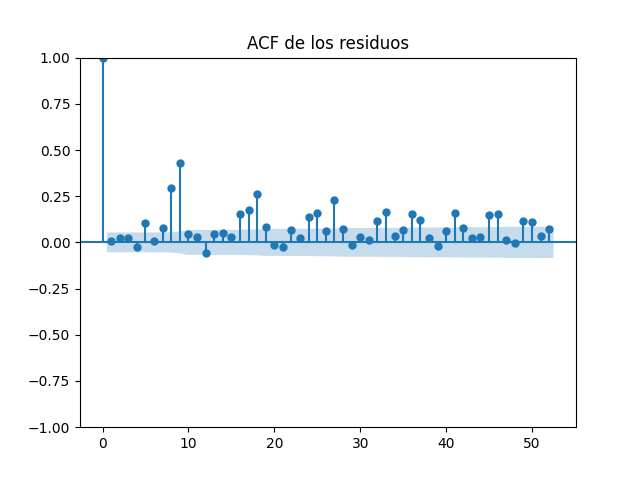

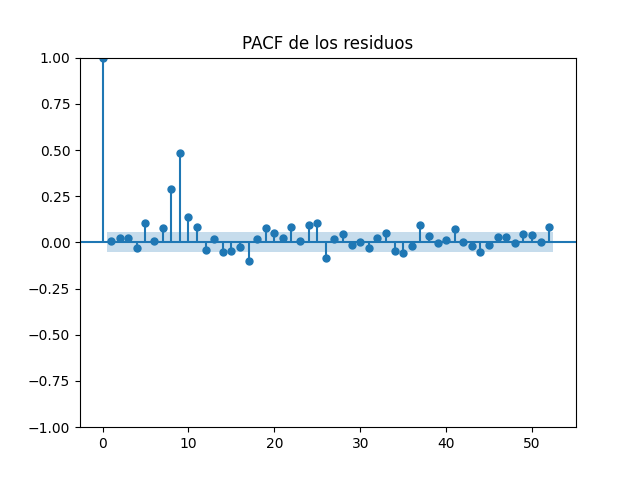

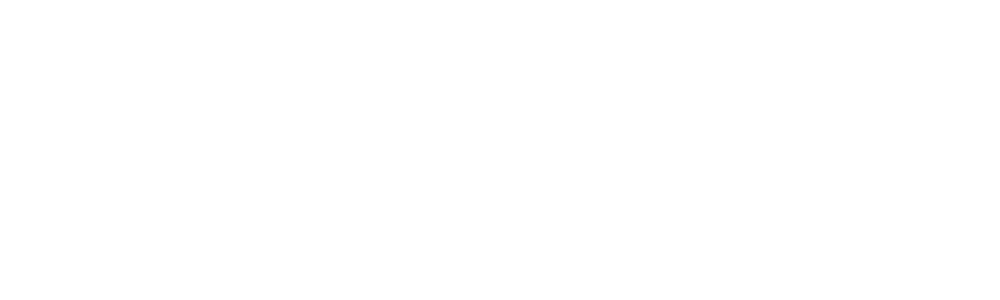

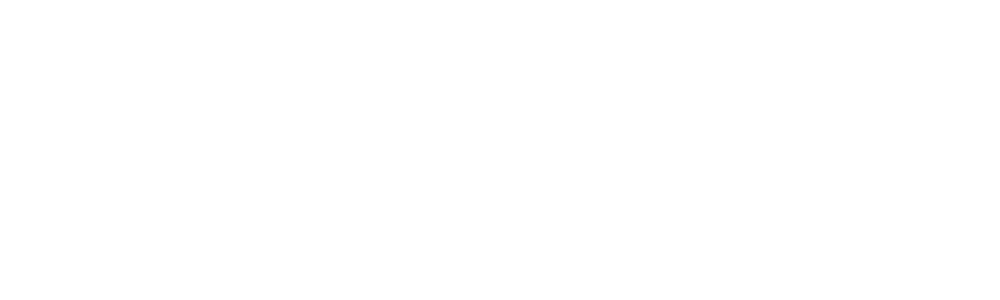

In [39]:
%matplotlib widget
# %matplotlib inline
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# # ACF
# plt.figure(figsize=(10, 3))
# plot_acf(data["volume.sales"], lags=52)  # Ajusta los 'lags' según tu preferencia
# plt.title("ACF - Autocorrelation Function")
# plt.show()

# # PACF
# plt.figure(figsize=(10, 3))
# plot_pacf(data["volume.sales"], lags=52)  # Ajusta los 'lags' según tu preferencia
# plt.title("PACF - Partial Autocorrelation Function")
# plt.show()

# %matplotlib widget
# Residuals analysis
residuals = model.resid

""" No he podido cambiar el area de significancia del 95% a otro valor"""


# Graficar ACF de los residuos
plt.figure(figsize=(10, 3))
plot_acf(residuals, lags=52)
plt.title("ACF de los residuos")
plt.show()

# Graficar PACF de los residuos
plt.figure(figsize=(10, 3))
plot_pacf(residuals, lags=52)
plt.title("PACF de los residuos")
plt.show()

In [24]:
# def arimax_model(data_filtered, p, d, q):
#     # Convertimos a dummies
#     data_dummies = pd.get_dummies(
#         data_filtered, columns=["supermarket", "variant"], drop_first=True
#     )

#     # Definir X (variables exógenas)
#     X = data_dummies[
#         [
#             "unit.sales",
#             "value.sales",
#             "supermarket_supermarket-B",
#             "supermarket_supermarket-C",
#             "supermarket_supermarket-D",
#             "variant_light",
#             "variant_standard",
#             "variant_vegan",
#         ]
#     ]

#     # Variable dependiente (serie temporal)
#     y = data_dummies["volume.sales"]

#     # Ajustamos el modelo ARIMAX con las variables exógenas (X)
#     model_arimax = SARIMAX(y, exog=X, order=(p, d, q)).fit()

#     return model_arimax


# # Ajustamos el modelo ARIMAX si hay autocorrelación
# # p, d, q pueden ajustarse dependiendo de los resultados del ACF/PACF de la serie original
# arimax_result = arimax_model(data_dummies, p=1, d=1, q=1)
# plt.show()